# Analysis Notebook

## Dependencies

Let's first load the dependencies.

In [1]:
#Import packages.
import wandb
import pandas as pd
api = wandb.Api()
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

# Function to load from W&B

To load the data from WandB, let's write a function.

In [2]:
#Function that loads a sweep from W&B.
def load_sweep(sweep_id, warnings=True):
    
    sweep = api.sweep(f"wakewordteam/02460AdvancedML/{sweep_id}")
    sweep_runs = sweep.runs

    summary_list, config_list, name_list = [], [], []
    for run in sweep_runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    #Discard the ones that are currently running.
    runs_df = runs_df.loc[runs_df['summary'].apply(lambda x : len(x) != 0)]
    
    config_elements = list(runs_df['config'].iloc[0].keys()) 
    summary_elements = list(runs_df['summary'].iloc[0].keys())

    columns = [f'config_{x}' for x in config_elements]
    columns += [f'summary_{x}' for x in summary_elements if x not in config_elements]

    def try_extract(d, k):
        #Try to extract from a dictionary, otherwise it faills.
        try:
            return d[k]
        except:
            if warnings:
                print(f'Could not extract {k} from {d}')
            return None

    for col in columns:
        if 'config_' in col:
            runs_df[col] = runs_df['config'].apply(lambda x : try_extract(x, col.replace('config_','')))
        elif 'summary_' in col:
            runs_df[col] = runs_df['summary'].apply(lambda x : try_extract(x, col.replace('summary_','')))
        else:
            continue

    runs_df.drop(['summary', 'config'], axis=1, inplace=True)

    runs_df.reset_index(drop=True, inplace=True)
    return runs_df

# Experiment 1

## Sweep over $(\textrm{A}, \mu)$

Here, we want to make plot Figure 2a in the paper.


In [ ]:
plt.style.use('seaborn')
runs_df = load_sweep('9t6u397w', warnings=False) #(A, mu, seed=0..10) for GCN.
runs_df = runs_df.loc[runs_df['config_seed'].isin(np.arange(1,11))] #We accidently set seed = 0, 1, ... 10, so we filter it out.

runs_df['summary_test_acc'] = runs_df['summary_test_acc'] * 100

sweep_mu_A_df = runs_df.groupby(['config_A', 'config_mu']).agg(
    test_acc_mean = ('summary_test_acc', 'mean'),
    test_acc_std  = ('summary_test_acc', 'std')
).reset_index().groupby(['config_mu']).agg(lambda x : list(x)).reset_index()

plt.figure(figsize=(10,6))

#Set title and align it on the left side.
#plt.title('Test Accuracy ', fontsize=20, y=1.05)

for _, (config_mu, config_A, test_acc_mean, test_acc_std) in sweep_mu_A_df.iterrows():
    plt.errorbar(config_A, test_acc_mean, test_acc_std, label=r'GCN, $\mu$ = ' + str(config_mu), capsize=5, elinewidth=3, markeredgewidth=3)
    plt.legend(fontsize=20, loc='lower right')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    break #Only take mu=0

runs_df = load_sweep('i0bg9s2c', warnings=False)
runs_df = runs_df.loc[runs_df['config_seed'].isin(np.arange(1,11))] #We accidently set seed = 0, 1, ... 10, so we filter it out.

runs_df['summary_test_acc'] = runs_df['summary_test_acc'] * 100

sweep_mu_A_df = runs_df.groupby(['config_A', 'config_mu']).agg(
    test_acc_mean = ('summary_test_acc', 'mean'),
    test_acc_std  = ('summary_test_acc', 'std')
).reset_index().groupby(['config_mu']).agg(lambda x : list(x)).reset_index()


for _, (config_mu, config_A, test_acc_mean, test_acc_std) in sweep_mu_A_df.iterrows():
    plt.errorbar(config_A, test_acc_mean, test_acc_std, label=r'GAT, $\mu$ = ' + str(config_mu), capsize=5, elinewidth=3, markeredgewidth=3)
    plt.legend(fontsize=20, loc='lower right')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    break #Only take mu=0

#Set xticks to mu_A.
plt.xticks(runs_df['config_A'].unique())

plt.xlabel('Num. of training nodes per class', fontsize=20)
plt.ylabel('Test Accuracy (%)', fontsize=20)
plt.ylim(67.5, 87.5)

#Save figure and remove whitespace.
plt.tight_layout()
plt.savefig('figures/sweep_mu_A.png', dpi=300)

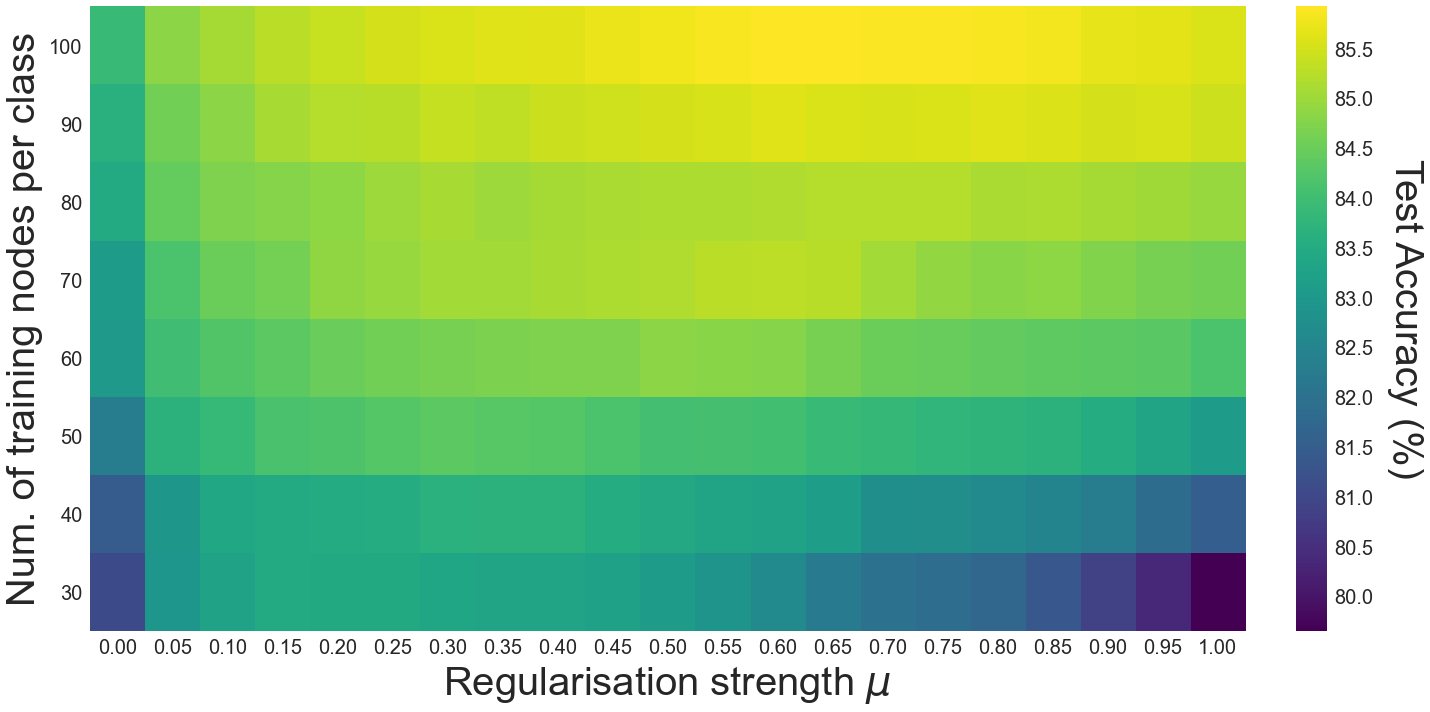

In [10]:
runs_df = load_sweep('9t6u397w', warnings=False) #(A, mu, seed=0..10) for GCN.
runs_df = runs_df.loc[runs_df['config_seed'].isin(np.arange(1,11))] #We accidently set seed = 0, 1, ... 10, so we filter it out.
runs_df['summary_test_acc'] = runs_df['summary_test_acc'] * 100

X_df = runs_df.loc[runs_df['config_A'] >= 30].groupby(['config_mu','config_A']).agg(test_acc_mean = ('summary_test_acc', 'mean'), test_acc_std = ('summary_test_acc', 'std')).reset_index()\
       .pivot(index='config_mu', columns='config_A', values='test_acc_mean')



x, y = X_df.index.to_numpy(), X_df.columns.to_numpy()

#Make meshgrid of x and y
X, Y = np.meshgrid(x, y)

#Plot X_df on top of image
plt.figure(figsize=(20,10))

#Plot heatmap on top of X and Y grid.
plt.imshow(X_df.T, cmap='viridis', interpolation='none', origin='lower', aspect='auto')

#Remove grid.
plt.grid(False)

#Set xtick labels.
plt.xticks(np.arange(len(x)), [f'{x_tick:.2f}' for x_tick in x], fontsize=20)

#Set ytick labels.
plt.yticks(np.arange(len(y)), y, fontsize=20)

plt.xlabel('Regularisation strength $\mu$', fontsize=40, labelpad=6)
plt.ylabel('Num. of training nodes per class', fontsize=40, labelpad=6)

#Set colorbar with same height of image and more ticks.
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks(np.arange(79, 87, 0.5))

#Set colorbar ticksize
cbar.ax.tick_params(labelsize=20)

#Set title for the colorbar
cbar.set_label('Test Accuracy (%)', fontsize=20)

#Rotate colorbar label
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), rotation=270, fontsize=40, labelpad=50)

plt.tight_layout()
plt.savefig('figures/A_mu_image.png', dpi=300)

In [7]:
X_df

config_A,30,40,50,60,70,80,90,100
config_mu,,,,,,,,
0.00,0.810689,0.814786,0.822816,0.830201,0.830929,0.834777,0.836333,0.838695
0.05,0.829384,0.829736,0.836853,0.839948,0.841344,0.844413,0.845910,0.848257
0.10,0.832746,0.834226,0.838634,0.842264,0.845176,0.846974,0.848268,0.850647
0.15,0.834908,0.834761,0.841094,0.843313,0.846123,0.847905,0.851011,0.852639
0.20,0.834508,0.835132,0.841688,0.844974,0.848738,0.848464,0.852166,0.853934
0.25,0.834668,0.835379,0.842578,0.845892,0.849594,0.850047,0.852406,0.855129
0.30,0.833667,0.836491,0.843469,0.846285,0.850451,0.851024,0.853705,0.855727
0.35,0.833106,0.836903,0.842833,0.846853,0.850586,0.849953,0.853272,0.856175
0.40,0.833026,0.836697,0.842706,0.847028,0.850947,0.850698,0.854139,0.856474


## $(\mu, \alpha)$-sweep

In [ ]:
runs_df = load_sweep('5pksx5v2', warnings=False)
#TODO: Append sweep e399eurp to this dataframe!


X_df = runs_df.groupby(['config_mu','config_unmask-alpha']).agg(test_acc_mean = ('summary_test_acc', 'mean'), test_acc_std = ('summary_test_acc', 'std')).reset_index()\
       .pivot(index='config_mu', columns='config_unmask-alpha', values='test_acc_mean')

x, y = X_df.index.to_numpy(), X_df.columns.to_numpy()

#Make meshgrid of x and y
X, Y = np.meshgrid(x, y)

#Plot X_df on top of meshgrid
plt.figure(figsize=(20,10))
plt.title(r'Test Accuracy vs. $\mu$ and $\alpha$ for $A=40$', fontsize=20)
plt.contourf(X, Y, X_df, cmap='viridis', alpha=1)
plt.xlabel(r'$\mu$' + '\nRegularisation strength', fontsize=20)
plt.ylabel('Unmask P-reg Ratio\n' + r'$\alpha$', fontsize=20)

plt.scatter(X.flatten(), Y.flatten(), c=X_df.values.flatten(), cmap='viridis', s=20)
plt.colorbar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Let'sa go

In [ ]:
runs_df = load_sweep('5pksx5v2', warnings=False)

X_df = runs_df.groupby(['config_mu','config_unmask-alpha']).agg(test_acc_mean = ('summary_test_acc', 'mean'), test_acc_std = ('summary_test_acc', 'std')).reset_index()\
       .pivot(index='config_mu', columns='config_unmask-alpha', values='test_acc_std')

x, y = X_df.index.to_numpy(), X_df.columns.to_numpy()

#Make meshgrid of x and y
X, Y = np.meshgrid(x, y)

#Plot X_df on top of meshgrid
plt.figure(figsize=(20,10))
plt.title(r'Test Accuracy vs. $\mu$ and $\alpha$ for $A=40$', fontsize=20)
plt.contourf(X, Y, X_df, cmap='viridis', alpha=1)
plt.xlabel(r'$\mu$' + '\nRegularisation strength', fontsize=20)
plt.ylabel('Unmask P-reg Ratio\n' + r'$\alpha$', fontsize=20)

plt.scatter(X.flatten(), Y.flatten(), c=X_df.values.flatten(), cmap='viridis', s=20)
plt.colorbar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## ($\mu$, seed)-sweep

In [ ]:
runs_df = load_sweep('3qss1stl', warnings=False)

for n, (_, config_mu, summary_test_acc) in runs_df.groupby(['config_A', 'config_mu'])['summary_test_acc'].apply(list).reset_index().iterrows():
    if n%2 == 0:
        plt.hist(summary_test_acc, bins=20, label=r'$\mu$ = ' + str(config_mu), alpha=0.3)
    else:
        continue
plt.legend()
plt.show()

## (A, $\kappa$)-sweep

In [ ]:
runs_df = load_sweep('xe327qk5', warnings=True)

In [ ]:
import seaborn as sns
heat_matrix = runs_df.groupby(['config_A', 'config_kappa']).agg(test_acc_mean = ('summary_test_acc', 'mean'), test_acc_std = ('summary_test_acc', 'std')).reset_index()\
       .pivot(index='config_A', columns='config_kappa', values='test_acc_mean')

sns.heatmap(heat_matrix, cmap='viridis')

## Cora

### A and Accuracy for $\mu = 0$

In [ ]:
runs_df = load_runs('8g92nt0k')
cora_experiment = runs_df.loc[
    (runs_df['config_dataset'] == 'Cora')
]

print('Shape of the dataset:')
print(cora_experiment.shape)
print('')

print('Columns:')
print(cora_experiment.columns)
print('')

experiment = cora_experiment.loc[cora_experiment['config_mu'] == 0].groupby(['config_A']).agg(
    test_acc_mean = ('summary_test_acc', lambda x : x.mean()),
    test_acc_std  = ('summary_test_acc', lambda x : x.std()),
).reset_index()

plt.figure(figsize=(15, 7))
plt.errorbar(x=experiment['config_A'].to_numpy(), y=experiment['test_acc_mean'].to_numpy(), yerr=experiment['test_acc_std'].to_numpy())
plt.xlabel('Num. of training nodes per class', fontsize=20)
plt.ylabel('Test Accuracy', fontsize=20)
plt.xlim([0, 110])
plt.xticks(np.arange(10, 110, 10), fontsize=20)
plt.title('Cora Dataset', fontsize=20)
plt.show()

### $\mu$ and Accuracy.

In [ ]:
runs_df = load_runs('8g92nt0k')
cora_experiment = runs_df.loc[
    (runs_df['config_dataset'] == 'Cora')
]

print('Shape of the dataset:')
print(cora_experiment.shape)
print('')

print('Columns:')
print(cora_experiment.columns)
print('')

experiment = cora_experiment.groupby(['config_A', 'config_mu']).agg(
    test_acc_mean = ('summary_test_acc', lambda x : x.mean()),
    test_acc_std  = ('summary_test_acc', lambda x : x.std()),
).reset_index().groupby(['config_A']).agg(
    mu = ('config_mu', list),
    test_acc_mean = ('test_acc_mean', list),
    test_acc_std  = ('test_acc_std', list)    
).reset_index()

plt.figure(figsize=(15, 7))
plt.style.use('seaborn')
for _, row in experiment.iterrows():
    A  = row['config_A']
    mu = row['mu']
    test_acc_mean = row['test_acc_mean']
    test_acc_std  = row['test_acc_std']

    plt.errorbar(mu, test_acc_mean, yerr=test_acc_std, label=f'Training nodes per class: {A}')

plt.xlabel('$\mu$', fontsize=20)
plt.ylabel('Test Accuracy', fontsize=20)
plt.legend(fontsize=20)
plt.show()

# Unit Testing

In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score

import sys

sys.path.append('../src/')

from GCN import GCN
from get_masks import get_masks
from PRegLoss import PRegLoss

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


In [ ]:
for mu in [0.25, 0.5, 1]:
    dataset = Planetoid(root=f'/tmp/Cora', name='Cora')

    #Unpack the dataset to get the data.
    data = dataset[0]

    model = GCN(num_node_features = dataset.num_node_features, num_classes = dataset.num_classes)
    #Then args.B is not none either.
    train_mask, val_mask, test_mask = get_masks(30, 0, dataset)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    from bhtsne import tsne
    model.eval()
    p_before = torch.softmax(model(data), dim=1).detach().numpy().flatten()
    X_before = model(data).detach().numpy().astype('float64')
    Y_before = tsne(X_before)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    loss_fn = torch.nn.CrossEntropyLoss()
    preg_loss_fn = PRegLoss(phi = 'squared_error', edge_index = data.edge_index, device=device)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)

        loss = loss_fn(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    p_after_train = torch.softmax(model(data), dim=1).detach().numpy().flatten()
    X_after_train = model(data).detach().numpy().astype('float64')
    Y_after_train = tsne(X_after_train)

    model.train()
    for epoch in range(200):
        optimizer.zero_grad()
        out = model(data)

        loss = mu * preg_loss_fn(out)
        loss.backward()
        optimizer.step()

    model.eval()
    p_after_preg  = torch.softmax(model(data), dim=1).detach().numpy().flatten()
    X_after_preg = model(data).detach().numpy().astype('float64')
    Y_after_preg = tsne(X_after_preg)

    plt.figure(figsize=(20,9))
    plt.subplot(2,3,1)
    plt.scatter(X_before[:, 0], Y_before[:, 1], c = data.y)
    plt.xticks([])
    plt.yticks([])
    plt.title('Before Training')

    plt.subplot(2,3,2)
    plt.scatter(Y_after_train[:, 0], Y_after_train[:, 1], c = data.y)
    plt.xticks([])
    plt.yticks([])
    plt.title('After Training')


    plt.subplot(2,3,3)
    plt.scatter(Y_after_preg[:, 0], Y_after_preg[:, 1], c = data.y)
    plt.xticks([])
    plt.yticks([])
    plt.title('After P-Reg')

    plt.subplot(2,3,4)
    plt.hist(p_before, bins='auto')

    plt.subplot(2,3,5)
    plt.hist(p_after_train, bins='auto')

    plt.subplot(2,3,6)
    plt.hist(p_after_preg, bins='auto')

    plt.suptitle(f'$\mu = {mu}$', fontsize=25)
    plt.show()

# Squared Error

In [ ]:
import torch
AZ = torch.tensor([[1,2,3],[4,5,6]]).double()

In [ ]:
Z = torch.tensor([[4,5,6],[7,8,9]]).double()

In [ ]:
(torch.norm(AZ - Z, p=2, dim=1)**2).sum()

In [ ]:
import numpy as np

np.sqrt(3**2 + 3**2 + 3**2)

In [ ]:
dataset = Planetoid(root=f'/tmp/Cora', name='Cora')

#Unpack the dataset to get the data.
data = dataset[0]

model = GCN(num_node_features = dataset.num_node_features, num_classes = dataset.num_classes)
#Then args.B is not none either.
train_mask, val_mask, test_mask = get_masks(30, 0, dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_fn = torch.nn.CrossEntropyLoss()
preg_loss_fn = PRegLoss(phi = 'squared_error', edge_index = data.edge_index, device=device)
model.train()

sq_term = []
ce_term = []

mu = 1e-5
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)

    sq_err = mu * preg_loss_fn(out)
    ce_err = loss_fn(out[train_mask], data.y[train_mask])
    loss = ce_err + sq_err

    loss.backward()
    optimizer.step()

    sq_term.append(sq_err.item())
    ce_term.append(ce_err.item())

In [ ]:
plt.plot(sq_term, label='Squared Error-term')
plt.plot(ce_term, label='Cross Entropy-term')
plt.legend()

# Cross Entropy P-Reg

In [ ]:
runs_df = load_runs('yjhb5onh', warnings=False)

experiment = runs_df.loc[runs_df['config_phi'] == 'cross_entropy'].groupby(['config_mu']).agg(
    test_acc_mean = ('summary_test_acc', lambda x : x.mean()),
    test_acc_std  = ('summary_test_acc', lambda x : x.std())
).reset_index()

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,5))
plt.errorbar(x=experiment.config_mu, y=experiment.test_acc_mean, yerr=experiment.test_acc_std)
plt.xlabel('$\mu$')
plt.ylabel('Test Accuracy')
plt.title('Cora, 100 training nodes per class, 10 different seeds', loc='left')
plt.show()

In [ ]:
torch.max(0, 1)

In [ ]:
tau = 0.1
torch.maximum(torch.tensor([0]), preg_loss_fn(out) - 0)

# Bayesian Hyperparameter Tuning

In [ ]:
bayesian_sweep = load_sweep('pn2e49fj')

In [ ]:
bayesian_sweep['N'] = bayesian_sweep['name'].apply(lambda x : int(x.split('-')[-1]))
bayesian_sweep.sort_values(by='N', inplace=True)

In [ ]:
x = bayesian_sweep['config_mu'].values
y = bayesian_sweep['config_unmask-alpha'].values

In [ ]:
#Make a lineplot of (x,y)
plt.plot(x[:100], y[:100], 'r.-', alpha=0.4)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\alpha$')
plt.show()